In [1]:
!pip install ultralytics opencv-python numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00


In [2]:
import os

# Root directory of the KITTI dataset
kitti_base_path = "/kaggle/input/kitti-dataset"

# Training images and labels
kitti_images_dir = os.path.join(kitti_base_path, "data_object_image_2/training/image_2")
kitti_labels_dir = os.path.join(kitti_base_path, "data_object_label_2/training/label_2")

# YOLO dataset directories
yolo_dataset_path = "yolo_dataset"
yolo_images_train = os.path.join(yolo_dataset_path, "images/train")
yolo_images_val = os.path.join(yolo_dataset_path, "images/val")
yolo_labels_train = os.path.join(yolo_dataset_path, "labels/train")
yolo_labels_val = os.path.join(yolo_dataset_path, "labels/val")

# Create directories
os.makedirs(yolo_images_train, exist_ok=True)
os.makedirs(yolo_images_val, exist_ok=True)
os.makedirs(yolo_labels_train, exist_ok=True)
os.makedirs(yolo_labels_val, exist_ok=True)

print("Directories set up correctly.")


Directories set up correctly.


In [3]:
import shutil
import numpy as np
from tqdm import tqdm

# KITTI class labels
kitti_classes = ["Car", "Pedestrian", "Cyclist", "Truck", "Van","Misc"]

def convert_kitti_to_yolo(label_file, split="train"):
    with open(os.path.join(kitti_labels_dir, label_file), "r") as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        obj_class = parts[0]
        if obj_class in kitti_classes:
            x_min, y_min, x_max, y_max = map(float, parts[4:8])
            width = 1242  # Adjust if your image size differs
            height = 375

            x_center = ((x_min + x_max) / 2) / width
            y_center = ((y_min + y_max) / 2) / height
            bbox_width = (x_max - x_min) / width
            bbox_height = (y_max - y_min) / height

            yolo_class = kitti_classes.index(obj_class)
            new_lines.append(f"{yolo_class} {x_center} {y_center} {bbox_width} {bbox_height}\n")

    yolo_label_path = yolo_labels_train if split == "train" else yolo_labels_val
    with open(os.path.join(yolo_label_path, label_file), "w") as f:
        f.writelines(new_lines)

# Split dataset (80% train, 20% val)
image_files = sorted(os.listdir(kitti_images_dir))
split_idx = int(0.8 * len(image_files))

train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Process and move files
for file in tqdm(train_files, desc="Processing Training Data"):
    convert_kitti_to_yolo(file.replace('.png', '.txt'), "train")
    shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_train, file))

for file in tqdm(val_files, desc="Processing Validation Data"):
    convert_kitti_to_yolo(file.replace('.png', '.txt'), "val")
    shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_val, file))

print("KITTI annotations converted and dataset split.")


Processing Validation Data: 100%|██████████| 1497/1497 [00:39<00:00, 37.57it/s]

KITTI annotations converted and dataset split.


In [4]:
dataset_yaml = f"""\
path: /kaggle/working/yolo_dataset
train: images/train
val: images/val
names:
  0: Car
  1: Pedestrian
  2: Cyclist
  3: Truck
  4: Van
  5: Misc
"""

with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("Updated dataset.yaml file created")

Updated dataset.yaml file created


In [5]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # "yolov8s.pt" for a larger model

# Train the model
model.train(data="dataset.yaml", epochs=25, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.5MB/s]


Ultralytics 8.3.134 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=F

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4753.8±1435.5 MB/s, size: 801.3 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:33<00:00, 176.17it/s]


train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2630.7±2101.7 MB/s, size: 815.8 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:08<00:00, 180.82it/s]


val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.19G      1.398      1.698       1.09        136        640: 100%|██████████| 374/374 [01:22<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.17it/s]


                   all       1497       7836      0.464       0.38      0.411      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.31G      1.287      1.144      1.065        114        640: 100%|██████████| 374/374 [01:20<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


                   all       1497       7836      0.567      0.438      0.478      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.51G      1.248      1.032      1.057        161        640: 100%|██████████| 374/374 [01:20<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


                   all       1497       7836      0.611      0.454      0.506      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.51G      1.209     0.9466      1.045        201        640: 100%|██████████| 374/374 [01:20<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


                   all       1497       7836       0.61       0.47      0.519      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.51G      1.185      0.893      1.035        223        640: 100%|██████████| 374/374 [01:20<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


                   all       1497       7836       0.62      0.557      0.596      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.62G      1.148     0.8436      1.019        118        640: 100%|██████████| 374/374 [01:22<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


                   all       1497       7836      0.742      0.553      0.642      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.62G      1.132     0.8269      1.013        221        640: 100%|██████████| 374/374 [01:20<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.52it/s]


                   all       1497       7836      0.754      0.562      0.663      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.62G       1.11      0.795      1.005        169        640: 100%|██████████| 374/374 [01:20<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.52it/s]


                   all       1497       7836      0.697      0.606      0.682      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.62G       1.09     0.7763     0.9986        173        640: 100%|██████████| 374/374 [01:20<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.29it/s]


                   all       1497       7836      0.785      0.621      0.712      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.62G      1.068     0.7476     0.9905        220        640: 100%|██████████| 374/374 [01:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.25it/s]


                   all       1497       7836      0.739      0.632      0.718      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.62G      1.058     0.7339     0.9843        184        640: 100%|██████████| 374/374 [01:22<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]


                   all       1497       7836      0.758       0.67      0.736      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.62G      1.041     0.7116     0.9801        144        640: 100%|██████████| 374/374 [01:21<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


                   all       1497       7836      0.789      0.687      0.761      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.62G      1.022     0.6949     0.9753        142        640: 100%|██████████| 374/374 [01:22<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


                   all       1497       7836      0.827      0.684       0.77      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.62G      1.009     0.6809     0.9688        157        640: 100%|██████████| 374/374 [01:22<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.43it/s]


                   all       1497       7836      0.827      0.688      0.777      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.62G     0.9995     0.6713     0.9656        192        640: 100%|██████████| 374/374 [01:22<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


                   all       1497       7836      0.835      0.699       0.79      0.536
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.62G     0.9795     0.6454     0.9579         89        640: 100%|██████████| 374/374 [01:21<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.23it/s]


                   all       1497       7836      0.815        0.7      0.785      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.62G     0.9582     0.6226      0.952         86        640: 100%|██████████| 374/374 [01:21<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]


                   all       1497       7836      0.838      0.699        0.8      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.62G     0.9437      0.609     0.9493         74        640: 100%|██████████| 374/374 [01:20<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.32it/s]


                   all       1497       7836      0.844      0.704      0.801      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.62G     0.9223     0.5928     0.9386         97        640: 100%|██████████| 374/374 [01:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


                   all       1497       7836      0.849       0.72      0.807      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.62G     0.9086     0.5847     0.9346         73        640: 100%|██████████| 374/374 [01:19<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


                   all       1497       7836      0.847      0.726      0.817      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.62G     0.8944     0.5719     0.9318         99        640: 100%|██████████| 374/374 [01:19<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


                   all       1497       7836      0.864      0.744      0.825      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.62G     0.8791     0.5563     0.9261         73        640: 100%|██████████| 374/374 [01:19<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


                   all       1497       7836      0.853      0.746      0.831      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.62G     0.8683     0.5487     0.9203        105        640: 100%|██████████| 374/374 [01:20<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.39it/s]


                   all       1497       7836      0.861      0.749      0.833      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.62G      0.854     0.5385     0.9169         72        640: 100%|██████████| 374/374 [01:20<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


                   all       1497       7836      0.877      0.754      0.839      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.62G     0.8437     0.5301     0.9118         87        640: 100%|██████████| 374/374 [01:20<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


                   all       1497       7836      0.871      0.763      0.844      0.601

25 epochs completed in 0.641 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       7836      0.872      0.762      0.844      0.601
                   Car       1338       5693      0.906      0.879      0.943       0.74
            Pedestrian        349        873      0.824      0.564      0.714      0.395
               Cyclist        209        292      0.848      0.692      0.797      0.498
                 Truck        208        220      0.933      0.948      0.974      0.785
                   Van        421        553      0.862      0.796      0.878      0.663
                  Misc        164        205      0.861      0.695      0.761      0.525


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a4f36424d00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000217.png: 224x640 7 Cars, 37.7ms
Speed: 1.3ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)


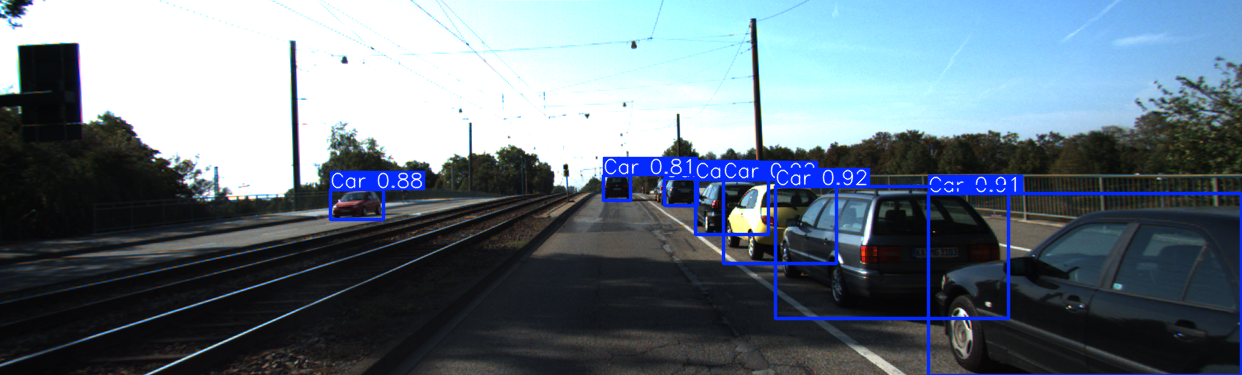

In [6]:
# model.val()
test_image = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000217.png" 

results = model(test_image)
results[0].show()

In [7]:
# Validate the model on the validation set
metrics = model.val()

# Extract mAP (Mean Average Precision)
mAP_50 = metrics.box.map50  # mAP at IoU=0.5
mAP_50_95 = metrics.box.map  # mAP at IoU=0.5:0.95

print(f"Model Accuracy (mAP@50): {mAP_50:.2f}")
print(f"Model Accuracy (mAP@50-95): {mAP_50_95:.2f}")

Ultralytics 8.3.134 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5030.3±1121.7 MB/s, size: 833.1 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:12<00:00,  7.74it/s]


                   all       1497       7836      0.872      0.762      0.845      0.602
                   Car       1338       5693      0.906       0.88      0.943      0.741
            Pedestrian        349        873       0.82      0.562      0.711      0.396
               Cyclist        209        292      0.851      0.688      0.796      0.498
                 Truck        208        220      0.933      0.948      0.974      0.788
                   Van        421        553      0.861      0.794      0.878      0.662
                  Misc        164        205      0.862      0.699       0.77      0.527


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train2
Model Accuracy (mAP@50): 0.85
Model Accuracy (mAP@50-95): 0.60



image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000217.png: 224x640 7 Cars, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


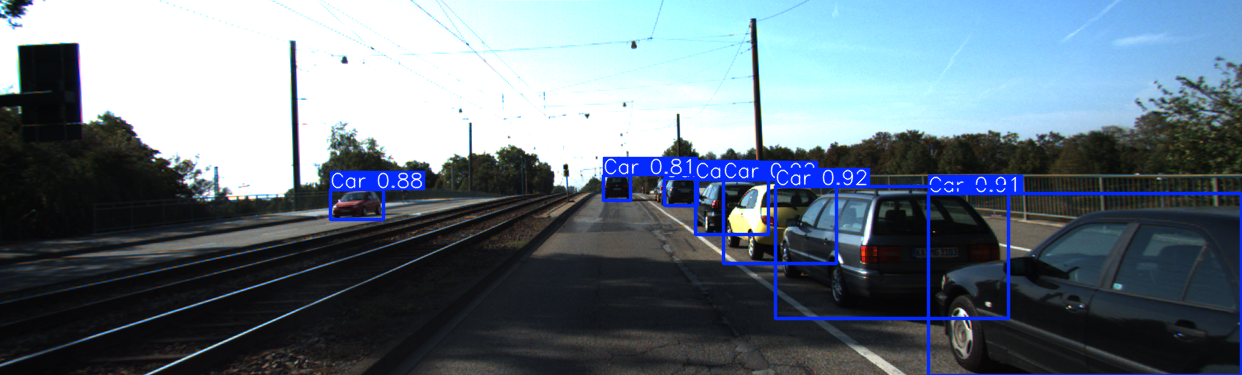

In [8]:
from ultralytics import YOLO

# 1) حمِّل الأوزان (checkpoint) وليس الصورة
model = YOLO("/kaggle/input/yolobest/pytorch/default/1/best.pt", task="detect")

# 2) الآن استخدم طريقة predict ولا تنسى أن تمرّر source
results = model.predict(source="/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000217.png", imgsz=640)

# results هي قائمة، فاختَر العنصر الأول
res = results[0]

# ثم اعرضه
res.show()


In [9]:
import time
import cv2
from ultralytics import YOLO

# 1) حمّل الموديل
model = YOLO("/kaggle/input/yolobest/pytorch/default/1/best.pt", task="detect")

# 2) حضّر صورة واحدة (أو اطار من فيديو) للتكرار عليها
img = cv2.imread("/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000217.png")
# إن احتجت لضبط الحجم:
# img = cv2.resize(img, (640, 640))

# 3) إحماء (لتجاوز زمن التحميل الأوّلي للـGPU)
for _ in range(5):
    _ = model.predict(source=img, imgsz=640, device=0)

# 4) القياس الفعلي
N = 50  # عدد التكرارات
start = time.time()
for _ in range(N):
    _ = model.predict(source=img, imgsz=640, device=0)
end = time.time()

# 5) حساب FPS
total_time = end - start
fps = N / total_time
print(f"Average inference time per image: {total_time/N*1000:.1f} ms")
print(f"=> Approximate FPS: {fps:.1f}")



0: 224x640 7 Cars, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 5.9m